In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [2]:
import warnings
from jupyterthemes import jtplot

In [3]:
jtplot.style()
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [30]:
class BaseModel:
    def __init__(self):
        self.train = None # 训练集
        self.test = None # 测试集
        self.train_label = None # 训练集标签
        self.features = None # 训练时使用的参数
        self.cat_feats = None # 训练时使用的参数中的类别参数
    
    def load_data(self, path):
        """
        读取数据
        @param: path:数据存放根目录
        """
        print('Loading data...', end='\t')
        self.train = pd.read_csv(path+'f:/PycharmProjects/ Identify-untrustworthy-companies/train.csv')
        self.test = pd.read_csv(path+'F:/PycharmProjects/ Identify-untrustworthy-companies/dataset/test.csv')
        self.train_label = pd.read_csv(path+'F:/PycharmProjects/ Identify-untrustworthy-companies/dataset/train_label.csv')
        self.submit = pd.read_csv(path+'F:/PycharmProjects/ Identify-untrustworthy-companies/dataset/submission.csv')
        print('Done!')
    
    def _missing_counter(self, df, cols=None):
        """
        统计数据缺失情况
        @param: df:数据集
        @param: cols:要统计缺失情况的特征列表
        """
        if cols is None:
            cols = df.columns
        counter = pd.DataFrame(columns=['Feature','Count','Percent'])
        length = df.shape[0]
        counter['Feature'] = cols
        counter = counter.set_index('Feature')
        for f in cols:
            n = sum(df[f].isna())
            p = n / length
            counter['Count'].loc[f] = n
            counter['Percent'].loc[f] = p
        return counter[counter['Count']!=0]
    def preprocess(self):
        """
        数据预处理（数据清洗等）
        """
        print('Preprocessing...', end='\t')
        # 处理缺失值
        counter = self._missing_counter(self.train)
#         for i in range(counter.shape[0]):
#             print(counter.iloc[i])
        counter.reset_index(inplace=True)
        feats1 = counter[counter['Count']==8343]['Feature'].values.tolist()   # 后面特征，count全都在8343 这里
        counter = counter[counter['Count']!=8343]
        counter = counter[counter['Percent']<0.6]    #缺失值实在太多了，大多数缺失比例都在一半以上，这里把缺失值填充范围扩大一点
#         print(counter['Feature'])
        feats2 = counter['Feature'].values.tolist()
        feats = feats1 + feats2
        all_df = pd.concat([self.train, self.test]) 
        for df in [self.train, self.test]:  # 把缺失值在58%的 都填上
            df = df[feats]
            for f in feats:
                if df[f].dtype!=object:
                    df[f] = df[f].fillna(all_df[f][~all_df[f].isna()].mean()) 
        print("Done!")
    
    def feature_engineering(self):
        """
        特征工程
        """
        print('Feature engineering ...', end='\t')
        self.train = pd.merge(self.train, self.train_label, on='ID', how='left')
        #* ---------------------------------------------------------------------------
        train = self.train.copy()
        test = self.test.copy()
        for df in [train, test]:
            df['总税'] = df['印花税'] + df['增值税'] + df['企业所得税'] + df['城建税']
            df['注册资本税收比'] = df['注册资本'] / df['总税']
             # 通过查询邮政编码的含义，中间两位代表市，可能提取出来作用更大一些
            df['邮政编码'] = df['邮政编码'].str[:4]
            # 看到图中的行业代码影响力很大。所以查询以下四位数有什么代表含义。四位数包括 大类两位数，中类三位数（包括大类的两位数），小类四位数
            # 所以想把大类 或者种类单独提取出来，行业代码是float64位的数而不是字符串
            #df['行业代码'] = df['行业代码'].astype(str).str[:2]
            # df['长期负债合计_差值'] = df['长期负债合计_年末数'] - df['长期负债合计_年末数']
            # df['长期借款_差值'] = df['长期借款_年末数'] - df['长期借款_年初数']
            # df['货币资金_差值'] = df['货币资金_年末数']- df['货币资金_年初数']
            # df['未分配利润_差值'] = df['未分配利润_年末数'] - df['未分配利润_年初数']
            # df['其他应收款_差值'] = df['其他应收款_年末数'] - df['其他应收款_年初数']
            # df['所有者权益合计_差值'] = df['所有者权益合计_年末数'] - df['所有者权益合计_年初数']
            # df['应收账款_差值'] = df['应收账款_年末数']- df['应收账款_年初数']
            #df['企业所得税与增值税之比'] = df['企业所得税']/df['增值税']
            df['11111资产结构_年初数'] = df['流动资产合计_年初数'] / df['非流动资产合计_年初数']
            df['11111资产结构_年末数'] = df['流动资产合计_年末数'] / df['非流动资产合计_年末数']
            df['11111资产结构_差值'] = df['11111资产结构_年末数'] - df['11111资产结构_年初数']
# 去掉下面的特征，分数又高了
#             df['11111固定资产长期股权投资之比_年初数'] = df['固定资产合计_年初数']/ df['长期股权投资_年初数']
#             df['11111固定资产长期股权投资之比_年末数'] = df['固定资产合计_年末数']/ df['长期股权投资_年末数']
#             df['11111固定资产长期股权投资之比_差值'] = df['11111固定资产长期股权投资之比_年末数'] - df['11111固定资产长期股权投资之比_年初数']



            df['11111存货其他流动资产之比_年初数'] = df['存货_年初数'] / df['其他流动资产_年初数']
            df['11111存货其他流动资产之比_年末数'] = df['存货_年末数'] / df['其他流动资产_年末数']
            df['11111存货其他流动资产之比_差值'] = df['11111存货其他流动资产之比_年末数'] - df['11111存货其他流动资产之比_年初数']
            
#             df['固定资产其他资产之比_年初数'] = df['固定资产合计_年初数'] / df['无形资产及其他资产合计_年初数']
#             df['固定资产其他资产之比_年末数'] = df['固定资产合计_年末数'] / df['无形资产及其他资产合计_年末数']
#             df['固定资产其他资产之比_差值'] = df['固定资产合计_年末数'] / df['无形资产及其他资产合计_年初数']

            
            
            df['11111资金来源结构_年初数'] = df['实收资本（股本）_年初数'] / df['负债合计_年初数']
            df['11111资金来源结构_年末数'] = df['实收资本（股本）_年末数'] / df['负债合计_年末数']
            df['11111资金来源结构_差值'] = df['11111资金来源结构_年末数'] - df['11111资金来源结构_年初数']
            
            # 下面的没有什么改进
#             df['资金来源结构2_年初数'] = df['实收资本（或股本）净额_年初数'] / df['负债合计_年初数']
#             df['资金来源结构2_年末数'] = df['实收资本（或股本）净额_年末数'] / df['负债合计_年末数']
#             df['资金来源结构2_差值'] = df['资金来源结构2_年末数'] - df['资金来源结构2_年初数']
            
            
            #df['资产负债匹配_1_年初数'] = df['非流动资产合计_年初数']/df['长期负债合计_年初数']   # 图上显示 此特征_年初数和年末数都没啥重要
            #df['资产负债匹配_1_年末数'] = df['非流动资产合计_年末数']/df['长期负债合计_年末数']
            
            
            df['11111资产负债匹配_2_年初数'] = df['流动资产合计_年初数']/df['短期借款_年初数']
            df['11111资产负债匹配_2_年末数'] = df['流动资产合计_年末数']/df['短期借款_年末数']
            df['11111资产负债匹配_2_差值'] = df['11111资产负债匹配_2_年末数'] - df['11111资产负债匹配_2_年初数']
            
            
#             df['11111流动比率_年初数'] = df['流动资产合计_年初数']/df['流动负债合计_年初数']
#             df['11111流动比率_年末数'] = df['流动资产合计_年末数']/df['流动负债合计_年末数']
#             df['11111流动比率_差值'] = df['11111流动比率_年末数'] - df['11111流动比率_年初数']
            
#             df['速动比率_年初数'] = (df['流动资产合计_年初数'] - df['存货_年初数'])/df['流动负债合计_年初数']           
#             df['速动比率_年末数'] = (df['流动资产合计_年末数'] - df['存货_年末数'])/df['流动负债合计_年末数'] 
#             df['速动比率_差值'] = df['速动比率_年末数'] - df['速动比率_年初数']
        # 把下面这组特征去掉，分数还高了点
        
#             df['11111负债结构_年初数'] = df['短期借款_年初数'] / df['长期负债合计_年初数']
#             df['11111负债结构_年末数'] = df['短期借款_年末数'] / df['长期负债合计_年末数']
#             df['11111负债结构_差值'] = df['11111负债结构_年末数'] - df['11111负债结构_年初数']
            #******************
            #在这里添加自己的特征工程部分，参考上两行
            #******************
            
        self.train = train.copy()
        self.test = test.copy()
        #* ---------------------------------------------------------------------------
        self.features = [_ for _ in self.train.columns 
                         if _ not in ['ID','Label','经营范围','经营期限至', '核准日期', '注销时间',
                                      '经营期限自', '成立日期', '行业代码']]
        # 解决新版本LGB输入数据集不支持中文特征的问题：临时将中文特征编码为整数
        map_columns = {self.features[i]:i for i in range(len(self.features))}
        self.train.rename(columns=map_columns, inplace=True)
        self.test.rename(columns=map_columns, inplace=True)
        self.cat_feats = ['企业类型','登记机关','企业状态','邮政编码','行业门类','企业类别','管辖机关']
        self.features = [map_columns[i] for i in self.features]
        self.cat_feats = [map_columns[i] for i in self.cat_feats]
        self.map_columns = {i[1]:i[0] for i in map_columns.items()}
        
        print("Done!")
    
    def gen_dataset(self, path=''):
        """
        高级封装，数据读取+数据预处理+特征工程
        @param: path:数据存储的根目录
        """
        self.load_data(path)
        self.preprocess()
        self.feature_engineering()
    
    def model_train(self, model, params, seed, early_stop=200):
        """
        模型训练
        @param: model:模型类型
        @param: params:模型参数
        @param: seed:随机数种子
        @param: early_stop:模型训练时的早停参数
        """
        if model=='LGB':
            oof, predictions, feature_importance_df = self._lgb_model(params, seed, early_stop)
        return oof, predictions, feature_importance_df
    def _lgb_model(self, params, seed=9816, early_stop=200):
        """
        使用LightGBM进行五折交叉训练
        @param: params:参数
        @param: seed:五折交叉验证时的随机数种子
        @param: early_stop:模型训练时的早停参数
        """
        train = self.train.copy()
        test = self.test.copy()
        target = train['Label']
        features = self.features.copy()
        cat_feats = self.cat_feats.copy()
        for f in cat_feats:
            for df in [train, test]:
                df[f] = df[f].astype('category')
                
        oof = np.zeros(train.shape[0])
        predictions = np.zeros(test.shape[0])
        feature_importance_df = pd.DataFrame()
        folds = StratifiedKFold(n_splits=5,random_state=4567,shuffle=True)
        for fold, (trn_idx,val_idx) in enumerate(folds.split(train.values, target.values)):
            print("Fold {}".format(fold))
            trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
            val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
            clf = lgb.train(
                params, 
                trn_data, 
                20000, 
                valid_sets = [trn_data, val_data], 
                verbose_eval=200, 
                early_stopping_rounds = early_stop,
                categorical_feature=cat_feats,
                )
            oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = [self.map_columns[i] for i in features]
            fold_importance_df["importance"] = clf.feature_importance()
            fold_importance_df["fold"] = fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
        print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
        return oof, predictions, feature_importance_df
    
    def gen_submit(self, pred, name='submit'):
        """
        生成提交文件
        @param: pred:预测结果
        @param: name:提交文件名称
        """
        submit = self.submit.copy()
        tmp = self.test.copy()
        tmp['pred'] = pred
        del submit['Label']
        submit = pd.merge(submit, tmp[['ID','pred']], on='ID', how='left')
        submit.rename(columns={'pred':'Label'},inplace=True)
        submit.to_csv(name+'.csv',index=False)

In [31]:
model = BaseModel()
# model.load_data('')


In [32]:
model.gen_dataset()
model.train.head(10)



Loading data...	Done!
Preprocessing...	Done!
Feature engineering ...	Done!


,ID,0,经营期限至,1,2,3,4,5,核准日期,行业代码,注销时间,经营期限自,成立日期,6,7,8,经营范围,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,Label,170,171,172,173,174,175,176,177,178,179,180,181,182,183
0,1,9.0,NaN,1.0,0.0,2663,19.110000,19.110000,00:00.0,5154.0,NaN,00:00.0,00:00.0,1.0,0.0,1.0,"[1412, 1024, 21375, 15023, 18526, 18789, 17022...",106.039650,0.331552,1.247218,3.181189,7.422776,0.0,0.0,25.110484,0.0,0.0,0.0,25.110484,797.386637,844.162546,0.0,772.276153,0.0,0.0,0.0,106.078436,0.0,50.220972,0.0,46.775910,-3.445063,0.0,0.0,0.0,0.0,125.552431,0.000000,0.0,520.839979,0.0,19.805307,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.013852,632.032182,0.0,585.013852,0.0,0.0,0.0,83.123866,0.0,50.220972,0.0,47.018330,-3.202643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,489.934244,0.0,11.955743,0.0,0.0,0.000000,0.000000,0.0,0.0,24.579246,462.290647,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,135.081011,0.0,135.081011,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,709.081535,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,215.371727,0.0,0.0,0.0,0.0,0.0,2.647788,4.192126,844.162546,0.0,31.416284,229.147518,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,80.128884,0.0,0.0,99.813781,0.0,99.813781,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,532.218401,0.0,0.0,20.088389,0.0,0.0,0.0,0.0,0.0,142.310005,0.0,0.0,0.0,0.0,0.0,28.122902,1.004419,632.032182,0.0,0,115.041196,0.166114,5.249306,5.332113,0.082808,inf,inf,NaN,0.062982,0.085846,0.022864,inf,inf,NaN
1,3,11.0,NaN,5.0,0.0,2660,29.154194,19.210446,00:00.0,7214.0,NaN,31:40.0,31:40.0,0.0,2.0,3.0,"[3671, 24856, 13525, 21079, 13219, 13694, 1442...",39.175600,51.244655,0.014363,1.175269,2.742293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,93.176911,0.206172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,0.0,NaN,3.0,0.0,2660,NaN,19.120045,13:31.0,2110.0,NaN,13:31.0,13:31.0,2.0,0.0,4.0,"[3671, 14394, 23662, 11227, 19205, 15633, 5344...",0.000000,0.000000,0.541067,4.637491,10.060346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.601413,1.803537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,0.0,42:05.0,9.0,0.0,2660,NaN,19.160223,00:00.0,5163.0,NaN,42:05.0,42:05.0,1.0,0.0,8.0,"[3287, 17425, 7503, 19922, 12217, 5089, 24884,...",0.027578,0.000000,0.008166,0.001318,0.001930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [33]:
# model.preprocess()
# model.train.head(5)

**注意：本例子中的所有随机种子都采用随机生成，即`int(np.random.rand()*100)`，这是为了避免大家直接 裸跑 这份代码产生和我一样的提交结果导致被主办方检测作弊封号。为了保证结果可复现，建议大家替换成一个自己设定的整数（别用2019，因为我跑这份代码的时候用的这个，当然如果你加入了自己的特征工程不是直接裸跑代码的话除外）**  
**强烈建议大家不要直接裸跑代码，没有意义。最好加入一些自己的特征工程，避免和别人跑出一样的分被封号。**

In [34]:
# model.train.head()

In [35]:
params = {
    'bagging_freq': 1,
    'bagging_fraction': 0.85,
    'bagging_seed': 33, #int(np.random.rand()*100),
    'boost': 'gbdt',
    'feature_fraction': 0.85,
    'feature_fraction_seed':35, #int(np.random.rand()*100),
    'learning_rate': 0.1,
    'max_depth': 12,  
    'metric':'auc',
    'min_data_in_leaf': 30,   #值为30时比较好
    'num_leaves': 128,   # 在 max_depth 为12时，num_leaves 的值在很大区间上改动没有影响分数
    'num_threads': 4,
    'objective': 'binary', 
    "lambda_l1": 0.5,
    'lambda_l2': 1.0,   # 1.0是最好的了，大于或小于它分都低一些
    'verbosity': 1,
    'is_unbalance':True
}

In [36]:
oof, pred, feat_importance = model.model_train('LGB', params, seed=int(np.random.rand()*100))

Fold 0
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.998811	valid_1's auc: 0.920826
Early stopping, best iteration is:
[20]	training's auc: 0.957545	valid_1's auc: 0.928323
Fold 1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.998761	valid_1's auc: 0.920242
Early stopping, best iteration is:
[25]	training's auc: 0.960202	valid_1's auc: 0.926526
Fold 2
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.998907	valid_1's auc: 0.912348
Early stopping, best iteration is:
[36]	training's auc: 0.97594	valid_1's auc: 0.920393
Fold 3
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.998893	valid_1's auc: 0.922162
Early stopping, best iteration is:
[22]	training's auc: 0.959999	valid_1's auc: 0.92987
Fold 4
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.998884	valid_1's auc: 0.897893
Early stopping, best itera

In [29]:
# 线下CV score:0.90713 线上0.923501

In [12]:
model.gen_submit(pred)

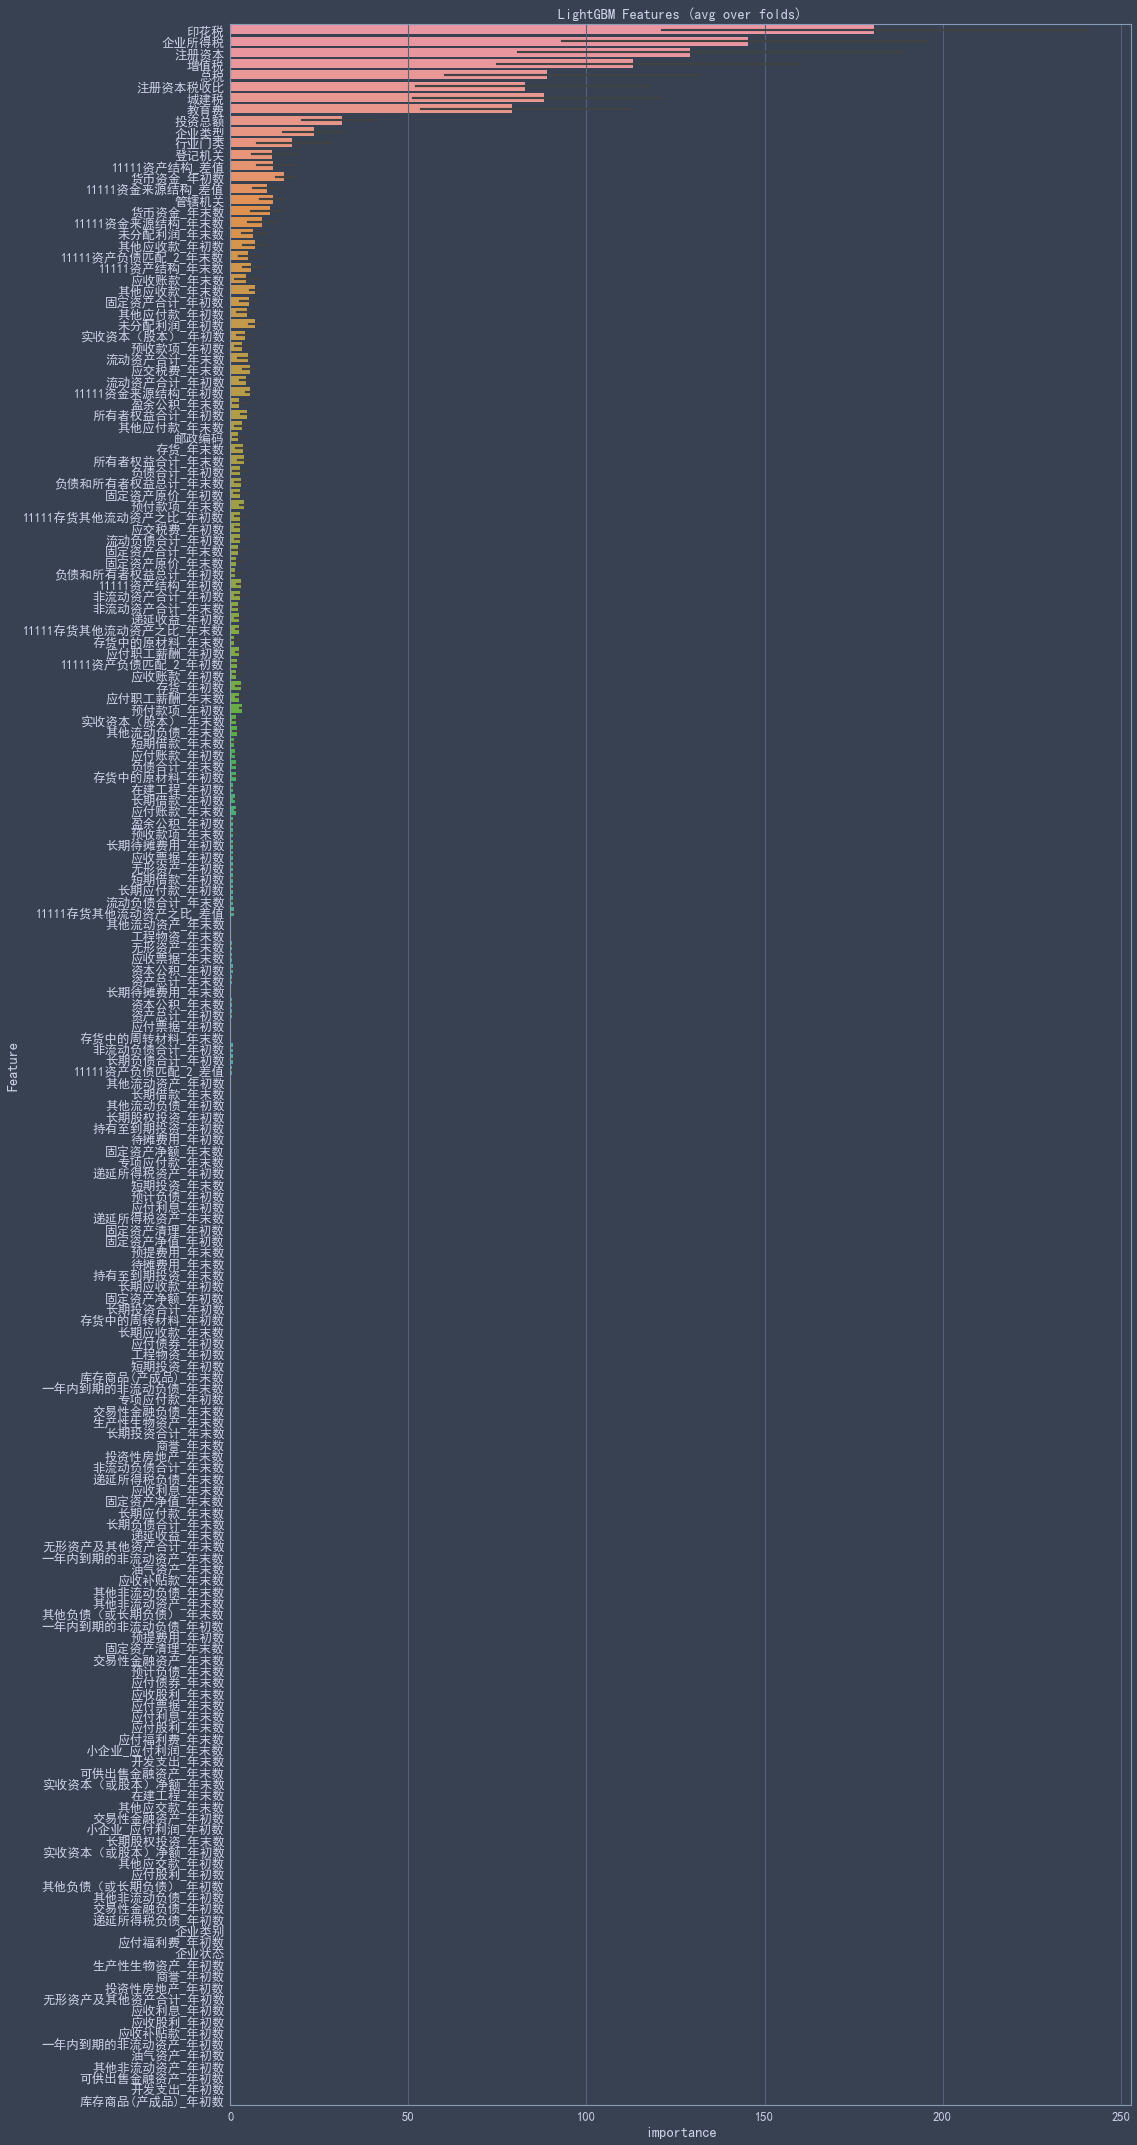

In [13]:
plt.figure(figsize=(16,30))
sns.barplot(x="importance",
            y="Feature",
            data=(feat_importance.sort_values(by="importance",ascending=False)))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [14]:
# 浅析企业信用评估的主要内容 http://kns.cnki.net//KXReader/Detail?TIMESTAMP=637114851804178750&DBCODE=CJFQ&TABLEName=CJFDLAST2019&FileName=YXJI201934109&RESULT=1&SIGN=Gf6hUzDVU0S979cgXL8JUUAj%2fKk%3d
# 中国建设银行企业信用评级指标体系  https://wenku.baidu.com/view/fb3e8673f242336c1eb95e12.html